In [10]:
import os

from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Load environment variables from .env file
load_dotenv()

True

In [11]:
# Load the countries_age_structure dataset
countries_age_structure_df = pd.read_csv(r'C:\Users\Nick\PycharmProjects\holman-olympic-data\datasets\countries_health\Coutries age structure.csv')
countries_age_structure_df.head()

,Country,Age 0 to 14 Years,Age 15 to 64 Years,Age above 65 Years
0,Japan,12.90%,60.10%,27%
1,Italy,13.50%,63.50%,23%
2,Portugal,13.60%,64.90%,22%
3,Germany,13.10%,65.50%,22%
4,Finland,16.40%,62.40%,21%


In [13]:
# Connect to the database
database_url = os.getenv("DATABASE_URL")
engine = create_engine(database_url, echo=False)

In [14]:
# Load the country_olympics data in from the database
country_olympics_df = pd.read_sql("SELECT * FROM country_olympics", con=engine)
country_olympics_df.head()

,country_id,country_name,total_medals,first_year,avg_medals_per_year,total_gold,total_silver,total_bronze,years_participated
0,afg,afghanistan,1,2012,1.000000,0,0,1,1
1,alb,albania,2,2024,2.000000,0,0,2,1
2,arg,argentina,27,1996,9.000000,7,8,12,7
3,arm,armenia,17,1996,5.666667,2,10,5,6
4,aus,australia,331,1994,30.090909,99,109,123,15


In [15]:
# merge dataframes on country name
countries_age_structure_df = countries_age_structure_df.rename(columns={"Country": "country_name"})
# lowercase the country_name column
countries_age_structure_df['country_name'] = countries_age_structure_df['country_name'].str.lower()

# join on the country_name column
merged_df = pd.merge(country_olympics_df, countries_age_structure_df, on='country_name', how='inner')
merged_df.head()


,country_id,country_name,total_medals,first_year,avg_medals_per_year,total_gold,total_silver,total_bronze,years_participated,Age 0 to 14 Years,Age 15 to 64 Years,Age above 65 Years
0,afg,afghanistan,1,2012,1.000000,0,0,1,1,43.20%,54.20%,3%
1,alb,albania,2,2024,2.000000,0,0,2,1,17.40%,68.90%,13%
2,arg,argentina,27,1996,9.000000,7,8,12,7,24.90%,63.90%,11%
3,arm,armenia,17,1996,5.666667,2,10,5,6,20.00%,68.80%,11%
4,aus,australia,331,1994,30.090909,99,109,123,15,19.00%,65.50%,16%


In [16]:
# it looks like the only year that has data for all countries is 2020, so let's load olympics_medals data for 2020
olympics_medals_df = pd.read_sql("SELECT * FROM olympics_medals WHERE year = 2020", con=engine)
olympics_medals_df.head()

,nation,gold,silver,bronze,total,year
0,USA,39,41,33,113,2020
1,CHN,38,32,19,89,2020
2,JPN,27,14,17,58,2020
3,GBR,22,20,22,64,2020
4,ROC,20,28,23,71,2020


In [23]:
# merge the olympics_medals data for 2020 with the countries_age_structure data on the country_name column
# first we need to merge the olympics_medals_df nation column on the noc_mapping table to get the country_name column
noc_mapping_df = pd.read_sql("SELECT * FROM noc_mapping", con=engine)
noc_mapping_df.head()

# merge the noc_mapping_df with the olympics_medals_df on the nation column
olympics_medals_df = pd.merge(olympics_medals_df, noc_mapping_df, left_on='nation', right_on='noc_code')
olympics_medals_df.head()
 
# capitalize the country_name column
countries_age_structure_df['country_name'] = countries_age_structure_df['country_name'].str.capitalize()

# merge the olympics_medals_df with the countries_age_structure_df on the country_name column
merged_df = pd.merge(olympics_medals_df, countries_age_structure_df)
merged_df.head()


,nation,gold,silver,bronze,total,year,country_name_x,noc_code_x,country_name_y,noc_code_y,country_name,noc_code,Age 0 to 14 Years,Age 15 to 64 Years,Age above 65 Years
0,CHN,38,32,19,89,2020,China,CHN,China,CHN,China,CHN,17.70%,71.70%,11%
1,JPN,27,14,17,58,2020,Japan,JPN,Japan,JPN,Japan,JPN,12.90%,60.10%,27%
2,AUS,17,7,22,46,2020,Australia,AUS,Australia,AUS,Australia,AUS,19.00%,65.50%,16%
3,FRA,10,12,11,33,2020,France,FRA,France,FRA,France,FRA,18.10%,62.20%,20%
4,ITA,10,10,20,40,2020,Italy,ITA,Italy,ITA,Italy,ITA,13.50%,63.50%,23%


In [24]:
# Convert age group percentages to numeric
merged_df['age_0_14'] = merged_df['Age 0 to 14 Years'].str.rstrip('%').astype(float)
merged_df['age_15_64'] = merged_df['Age 15 to 64 Years'].str.rstrip('%').astype(float)
merged_df['age_above_65'] = merged_df['Age above 65 Years'].str.rstrip('%').astype(float)

# Correlation between age groups and total medals
age_groups = ['age_0_14', 'age_15_64', 'age_above_65']
for group in age_groups:
    correlation = merged_df[['total', group]].corr().iloc[0, 1]
    print(f"Correlation between total medals and {group}: {correlation:.2f}")


Correlation between total medals and age_0_14: -0.33
Correlation between total medals and age_15_64: 0.05
Correlation between total medals and age_above_65: 0.40


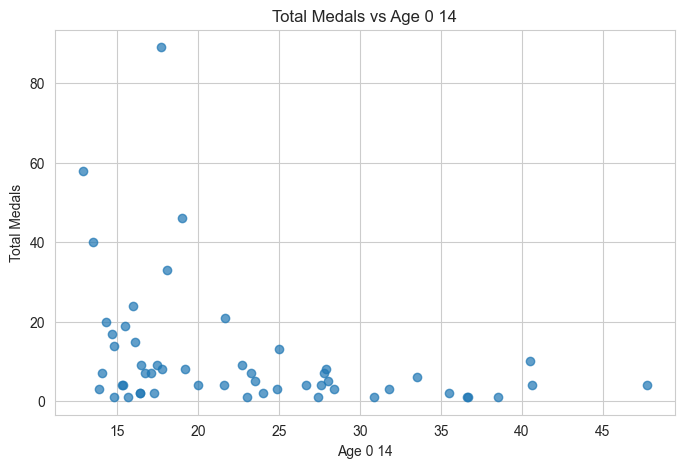

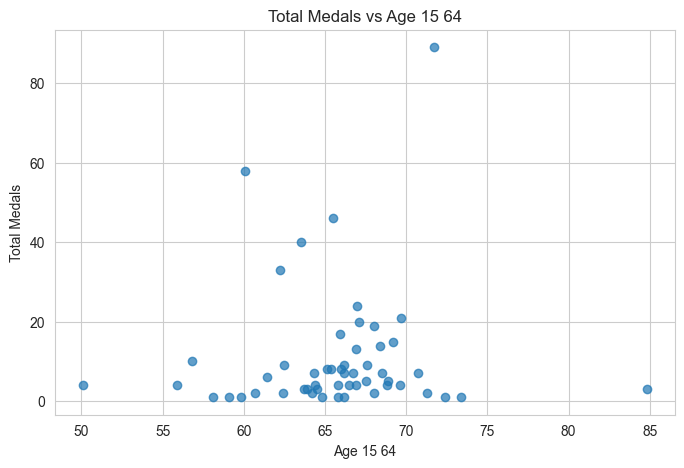

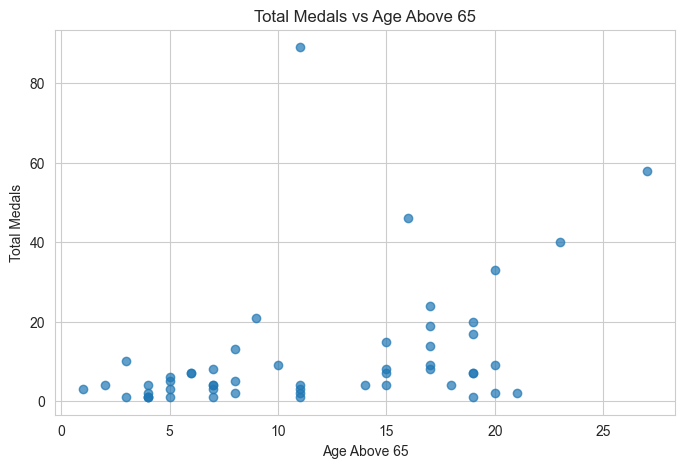

In [25]:
# Visualize age group percentage vs. total medals

for group in age_groups:
    plt.figure(figsize=(8, 5))
    plt.scatter(merged_df[group], merged_df['total'], alpha=0.7)
    plt.title(f"Total Medals vs {group.replace('_', ' ').title()}")
    plt.xlabel(group.replace('_', ' ').title())
    plt.ylabel("Total Medals")
    plt.grid(True)
    plt.show()


In [26]:
# Top 5 countries by total medals
top_countries = merged_df.nlargest(5, 'total')[['country_name', 'total', 'age_0_14', 'age_15_64', 'age_above_65']]
print(top_countries)


  country_name  total  age_0_14  age_15_64  age_above_65
0        China     89      17.7       71.7          11.0
1        Japan     58      12.9       60.1          27.0
2    Australia     46      19.0       65.5          16.0
4        Italy     40      13.5       63.5          23.0
3       France     33      18.1       62.2          20.0


In [28]:
# Countries by medal ordered by lowest age_above_65
countries_by_age = merged_df.sort_values('age_above_65')[['country_name', 'total', 'age_0_14', 'age_15_64', 'age_above_65']]
print(countries_by_age)

    country_name  total  age_0_14  age_15_64  age_above_65
23         Qatar      3      13.9       84.8           1.0
20        Uganda      4      47.7       50.1           2.0
10         Kenya     10      40.5       56.8           3.0
52         Ghana      1      38.5       58.1           3.0
45  Turkmenistan      1      30.9       64.8           4.0
42        Jordan      2      35.5       60.7           4.0
32      Ethiopia      4      40.6       55.9           4.0
50         Syria      1      36.6       59.1           4.0
43       Namibia      1      36.7       59.8           4.0
40    Kyrgyzstan      3      31.8       63.7           5.0
46        Brunei      1      23.0       72.4           5.0
17    Uzbekistan      5      28.0       67.5           5.0
31         Egypt      6      33.5       61.4           5.0
28         India      7      27.8       66.2           6.0
38    Azerbaijan      7      23.3       70.7           6.0
27     Venezuela      4      27.6       65.8           7